In [ ]:
import pandas as pd
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt 
import sys, os
import MySQLdb
sys.path.append(os.path.abspath("..")) 

# --- DB Connection ---
conn = MySQLdb.connect(
    host='127.0.0.1',
    port=3333,
    user=os.getenv("DB_USER"),
    passwd=os.getenv("DB_PASSWORD"),
    db=os.getenv("DB_NAME")
)

cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
sales_df = pd.read_sql("SELECT * FROM market_sales", conn)

df_26 = sales_df.merge(cards_df, on='card_id', how='left')

# --- Cleaning Function ---
def clean_group_hourly(g, min_price=200, min_trades=3, low_q=0.05, high_q=0.95):
    g = g.copy()
    g['sale_time'] = pd.to_datetime(g['sale_time']) 
    
    # Sort and set index for rolling
    g = g.sort_values("sale_time").set_index('sale_time')

    # Drop null / junk sales
    g = g[g['sold_price'].notnull() & (g['sold_price'] > min_price)]
    if len(g) < min_trades:
        return pd.DataFrame()  # nothing to return

    # --- Quantile filter ---
    low, high = g['sold_price'].quantile([low_q, high_q])
    cleaned = g[(g['sold_price'] >= low) & (g['sold_price'] <= high)].copy()
    outliers = g[(g['sold_price'] < low) | (g['sold_price'] > high)].copy()
    outliers['flag_reason'] = 'quantile_outlier'

    # --- Rolling median outlier detection ---
    if not cleaned.empty:
        cleaned['median_rolling'] = cleaned['sold_price'].rolling('1h', center=True).median()
        cleaned['deviation'] = abs(cleaned['sold_price'] - cleaned['median_rolling'])

        threshold = cleaned['sold_price'].median() * 0.4
        valid = cleaned['deviation'] < threshold

        rolling_outliers = cleaned[~valid].copy()
        rolling_outliers['flag_reason'] = 'rolling_median_outlier_hourly'

        # Keep valid cleaned sales
        cleaned = cleaned[valid].drop(columns=['median_rolling', 'deviation'], errors='ignore')
        outliers = pd.concat([outliers, rolling_outliers.drop(columns=['median_rolling','deviation'], errors='ignore')])
    else:
        cleaned = pd.DataFrame()

    # Add flag column
    if not cleaned.empty:
        cleaned['flag'] = 'cleaned'
    if not outliers.empty:
        outliers['flag'] = 'outlier'

    return pd.concat([cleaned.reset_index(), outliers.reset_index()], ignore_index=True)

# --- Apply across groups ---
results = df_26.groupby('card_id', group_keys=False).apply(clean_group_hourly).reset_index(drop=True)

# --- Split final datasets ---
df_clean_full = results[results['flag'] == 'cleaned'].drop(columns=['flag'])
df_outliers   = results[results['flag'] == 'outlier'].drop(columns=['flag'])

conn.close()

C:\Users\shane\AppData\Local\Temp\ipykernel_33296\2995837510.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  cards_df = pd.read_sql("SELECT * FROM cards WHERE game = 26", conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_33296\2995837510.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  sales_df = pd.read_sql("SELECT * FROM market_sales", conn)
C:\Users\shane\AppData\Local\Temp\ipykernel_33296\2995837510.py:44: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  cleaned['median_rolling'] = cleaned['sold_price'].rolling('1H', center=True).median()
C:\Users\shane\AppData\Local\Temp\ipykernel_33296\2995837510.py:44: FutureWar

## Correlation Between Mean Price of Cards and Demand of Cards Using **Pearson's Correlation Coefficient**

Using Frimpong as Subject

In [34]:
end_time = df_clean_full['sale_time'].max().floor('h')   # latest hour in data
start_time = end_time - pd.Timedelta(days=3)

frimpong_df = df_26[df_26['card_id'] == 882].copy()
print(frimpong_df['sale_time'].max().floor('h'))
df_24h_frimpong = frimpong_df[(frimpong_df['sale_time'] > start_time) & (frimpong_df['sale_time'] <= end_time)]

if df_24h_frimpong.empty:
    print("No trades in last 24h, using last 7 days instead")
    start_time = end_time - timedelta(days=7)
    df_24h_frimpong = frimpong_df[
        (frimpong_df['sale_time'] > start_time) & 
        (frimpong_df['sale_time'] <= end_time)
    ]
    


df_24h_frimpong['sale_hour'] = df_24h_frimpong['sale_time'].dt.floor('h')   # round down to the hou

frimpong_demand_df = (
    df_24h_frimpong.groupby(['card_id', 'sale_hour'])
    .size()
    .reset_index(name='sales_count')
)

frimpong_price_df = (
    df_24h_frimpong.groupby(['card_id', 'sale_hour'])
    ['sold_price'].median()   # or .mean()
    .reset_index(name='median_price')
)

def pearsons_corr(demand_df, price_df):
    merged = pd.merge(demand_df, price_df, on=['card_id', 'sale_hour'])
    if len(merged) < 2:
        return None  # not enough data points to calculate correlation
    return merged['sales_count'].corr(merged['median_price'])


r = pearsons_corr(frimpong_demand_df, frimpong_price_df)
print("Pearson correlation:", r)

2025-09-30 08:00:00
No trades in last 24h, using last 7 days instead
Pearson correlation: -0.029667521155543223


C:\Users\shane\AppData\Local\Temp\ipykernel_33296\692546274.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_24h_frimpong['sale_hour'] = df_24h_frimpong['sale_time'].dt.floor('h')   # round down to the hou


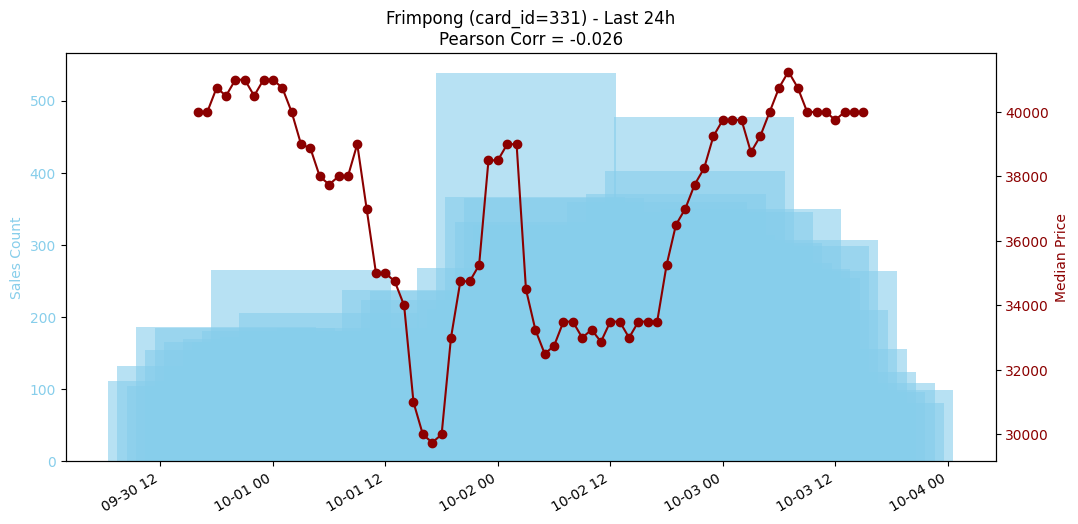

In [33]:
# Merge demand + price for plotting
frimpong_merged = pd.merge(frimpong_demand_df, frimpong_price_df, on=['card_id','sale_hour'])

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar plot for demand (sales_count)
ax1.bar(frimpong_merged['sale_hour'], frimpong_merged['sales_count'], 
        color='skyblue', alpha=0.6, label='Sales Count')
ax1.set_ylabel('Sales Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line plot for price (median_price)
ax2 = ax1.twinx()
ax2.plot(frimpong_merged['sale_hour'], frimpong_merged['median_price'], 
         color='darkred', marker='o', label='Median Price')
ax2.set_ylabel('Median Price', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

# Title with correlation
if r is None:
    plt.title("Frimpong (card_id=331) - Last 24h\nPearson Corr = Not enough data")
else:
    plt.title(f"Frimpong (card_id=331) - Last 24h\nPearson Corr = {r:.3f}")
fig.autofmt_xdate()
plt.show()